In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd
import glob
import json
from AutoEC_Lib import FindMolecules, DuckParams ,loadPine, loadGamry,MajoritySlope

In [2]:

    
def RedoxPeak(CV,peakParams,dt,scanRate,ax):
    CV_sub=CV.loc[(CV.scanrate<0) & (CV.cycle==0)]
    volts=np.array(CV_sub.V)
    current=np.array(CV_sub.C) 
    
    pBelow = MajoritySlope(volts,current,-1)
    
    peakIndex=np.argmin(current)
    peakV= volts[peakIndex ]
        
    peakC= current[peakIndex ]
    #          A         x    sig    m     b    A2            sig2     x2     power
    guess=[ peakC*.8,  peakV,  .1, .0001,  0,    peakC*.5,      10   ,  peakV ,  2]
    try:
        poptB, pcov = curve_fit(gaussian_Lin3,  volts ,current, guess) 
    except:
        pass
    
    flat_Current =(current-volts*pBelow[0]-pBelow[1])*-1
    flat_Current=flat_Current[flat_Current>0]
    plt.plot(volts*1000,1e6*current,'b')
    Q=np.sum(flat_Current)*dt
    
    IMin= peakC
    IMax=  np.poly1d(pBelow)(peakV)
    plt.plot( volts*1000,1e6*np.poly1d(pBelow)(volts),'r' )
    Ip=np.abs(IMax-IMin)
    peakParams['Abs Min (uA)']=peakC*1e6
    text=  'Imax=%.2f\nIp= %.2f uA\nEp= %.2f mV\n'%( peakC*1e6, Ip*1e6,1000*peakV)
    text += 'Q = %.2f uC\n'%(  Q*1e6)
    text += 'Kt = %.2f ms-1\nscanrate = %.2f'%( 1000*Ip/Q,scanRate)
    
    peakParams ['Ip_rx(uA)']=Ip*1e6
    peakParams ['Ep_rx(mV)']=1000*peakV
    peakParams ['Iback_rx(uA)']=1e6*pBelow[-1]  
    peakParams [ 'Q_rx (C)']=Q  
    peakParams [ 'Kt_rx(ms-1)']=1000*Ip/Q
    peakParams ['scanrate (mV/s)']=np.mean(np.abs(scanRate*1000))
    plt.text(.75, .5, text, ha='left', va='top', transform=ax.transAxes)
    plt.vlines(x=1000*peakV, ymin=1e6*IMin, ymax=1e6*IMax,colors='r')    
    return peakParams


def OxPeak(CV,peakParams,dt,scanRate,ax):
    
    CV_up=CV.loc[(CV.scanrate>0) & (CV.cycle==1)]
    volts_up=np.array(CV_up.V)
    current_up=np.array(CV_up.C) 
    ind=np.argsort(volts_up)
    volts_up=volts_up[ind]
    current_up=current_up[ind]   
    
    
    plt.plot(volts_up*1000,1e6*current_up,'y')
    
    pAbove = MajoritySlope(volts_up,current_up,1)
    #current_up=current_up[(volts_up>0)& (volts_up<.9)]
    #volts_up=volts_up[(volts_up>0) & (volts_up<.9)]
    flat_Current =current_up-volts_up*pAbove[0]-pAbove[1]
    
    
    peakIndex=np.argmax(current_up)
    peakV= volts_up[peakIndex ]
    peakC= current_up[peakIndex ]
    if np.abs(peakV-np.max(volts_up))<.05:
        peakIndex=np.argmax(flat_Current)
        peakV= volts_up[peakIndex ]
        peakC= flat_Current[peakIndex ]
        
    hm=np.max(flat_Current)/2   
    fwhm=peakIndex
    for i in range(peakIndex,len(flat_Current)):
        if flat_Current[i]<hm:
            fwhm=i
            break
    for i in range(peakIndex,0,-1):
        if flat_Current[i]<hm:
            fwhm=2*(volts_up[i ]-volts_up[fwhm ])
            break
    
    sigma =   2.355*fwhm
    

    
    #          A         x    sig    m     b    A2            sig2       x2      power
    guess=[ peakC*.8,  peakV,  .1, .0001,  0,    peakC*.1,      10   ,  peakV ,  2]
    try:
        poptU, pcov = curve_fit(gaussian_Lin3,  volts_up ,current_up, guess) 
    except:
        try:
            guess=[ peakC*.8,  peakV,  sigma, .0001,  0,    peakC*.1,      10   ,  peakV ,  2]
            poptU, pcov = curve_fit(gaussian_Lin3,  volts_up ,current_up, guess) 
        except:
            pass
    
     
    flat_Current=flat_Current[flat_Current>0]
   
    
    Q=np.sum(flat_Current)*dt
    IMax= peakC
    IMin=  np.poly1d(pAbove)(peakV)
    plt.plot( volts_up*1000,1e6*np.poly1d(pAbove)(volts_up) ,'r')
    peakParams['Abs Max (uA)']=peakC*1e6
    Ip=np.abs(IMax-IMin)
    
    text ='Max=%.2f\n, Ip= %.2f uA\nEp= %.2f mV\n'%( peakC*1e6, Ip*1e6,1000*peakV)
    text += 'Iback = %.2f uA\nQ = %.2f uC\n'%(1e6* pAbove[-1], Q*1e6)
    text += 'Kt = %.2f ms-1\n'%(1000*Ip/Q)
    text += 'FWHM = %.2f mV\n'%(1000* fwhm)
    
      
    plt.text(.01, .99, text, ha='left', va='top', transform=ax.transAxes)
    plt.vlines(x=1000*peakV, ymin=1e6*IMin, ymax=1e6*IMax,colors='r')
    
    peakParams['Ip_ox(uA)']=Ip*1e6
    peakParams['Ep_ox(mV)']=peakV*1000
    peakParams['Iback_ox (uA)']=1e6*pAbove[-1]
    peakParams['Q_ox (uC)']=Q*1e6
    peakParams['Kt_ox (ms-1)']=1000*Ip/Q
   
    return peakParams
        
def DuckParams(filename,CV,RedoxConcentration_M, nelectrons=1):
    f, ax = plt.subplots()
    plt.suptitle( os.path.basename( filename))
  
    plt.plot(CV.V*1000,CV.C*1e6,'k')
    plt.ylabel("Current (uA)")
    plt.xlabel('Potential (mV vs Ag/AgCl)')
    
    scanRate=np.mean(np.abs(CV.scanrate*1000))
    dt=    np.mean(np.diff(CV['Time']))
    
    peakParams ={ }
    peakParams=RedoxPeak(CV,peakParams,dt,scanRate,ax)
    peakParams=OxPeak(CV,peakParams,dt,scanRate,ax)
    
    Diffusion=  7.20E-06# ferrocene cm^2/s
    Diffusion = 8.70E-06 # HAR 
    Concentration=RedoxConcentration_M * 1e-3 #M

    R= 8.314 #J/mol/K 
    F=96485 #C/mol
    T=293  #K 
    Ip=50e-6

    area=Ip/.446*nelectrons*F*Concentration*(  nelectrons*F*scanRate/1000.0 *Diffusion/R/T )**.5*1e6
    
    const = (nelectrons*F )**2/4/R/T*scanRate/1000.0
    areaSF = Ip/(  const  )

    peakParams['E0(mV)']=(peakParams['Ep_ox(mV)']+peakParams ['Ep_rx(mV)'])/2
    peakParams['dE(mV)']=np.abs(peakParams['Ep_ox(mV)']+peakParams ['Ep_rx(mV)'])    
    
    text=''
    text += f'E0 = { peakParams["E0(mV)"]:.2f} mV\ndE = { peakParams["dE(mV)"]:.2f} mV\n' 
    text += f"EC Area = {    area   :.2f} cm^2\n"
    text += f"EC Bound Area = {    areaSF   :.2f} cm^2\n"
    plt.text(.99, .01, text, ha='right', va='bottom', transform=ax.transAxes)
  
    return peakParams
    

'D:\DataTemp\20231010testpad\CVs\20231009_chip1_Ruth_postRCA_BD.DTA'
'D:\DataTemp\20231010testpad\CVs\20231009_chip1_Ruth_postRCA_BD2.DTA'
'D:\DataTemp\20231010testpad\CVs\20231009_chip1_Ruth_postRCA_BE2.DTA'
'D:\DataTemp\20231010testpad\CVs\20231009_chip1_Ruth_postRCA_BG.DTA'
'D:\DataTemp\20231010testpad\CVs\20231009_chip1_Ruth_postRCA_BG2.DTA'
'D:\DataTemp\20231010testpad\CVs\20231009_chip1_Ruth_postRCA_TD.DTA'
'D:\DataTemp\20231010testpad\CVs\20231009_chip1_Ruth_postRCA_TG.DTA'
'D:\DataTemp\20231010testpad\CVs\20231009_goldRDE_C11_overnight_FcMeth_polished2_post_RD_ethanol_polish.DTA'
'D:\DataTemp\20231010testpad\CVs\20231009_goldRDE_C11_overnight_polished2_post_RD_ethanol_polish_Ruth.DTA'
'D:\DataTemp\20231010testpad\CVs\20231010_chip1_Ruth_postRCA_C11_BD.DTA'
'D:\DataTemp\20231010testpad\CVs\20231010_chip1_Ruth_postRCA_C11_BD2.DTA'
'D:\DataTemp\20231010testpad\CVs\20231010_chip1_Ruth_postRCA_C11_BD3.DTA'
'D:\DataTemp\20231010testpad\CVs\20231010_chip1_Ruth_postRCA_C11_BG.DTA'
'D:\

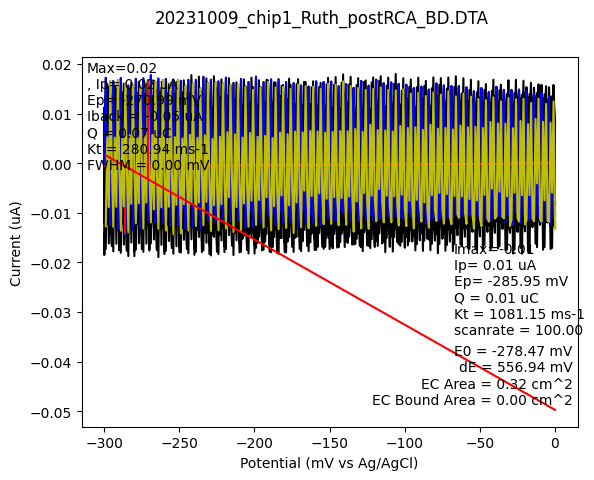

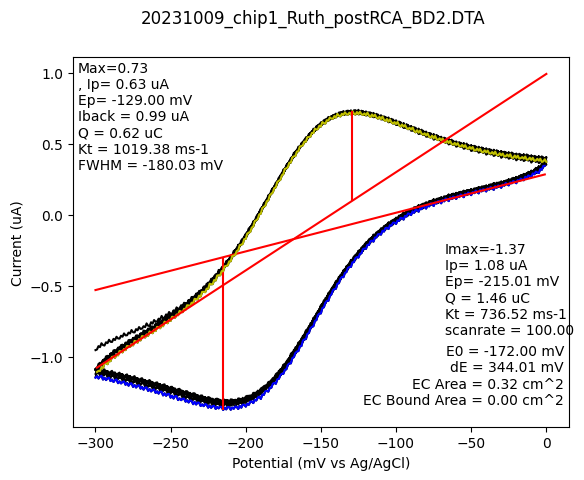

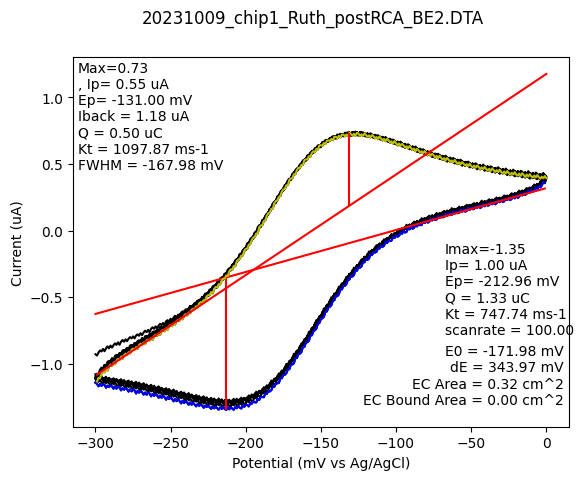

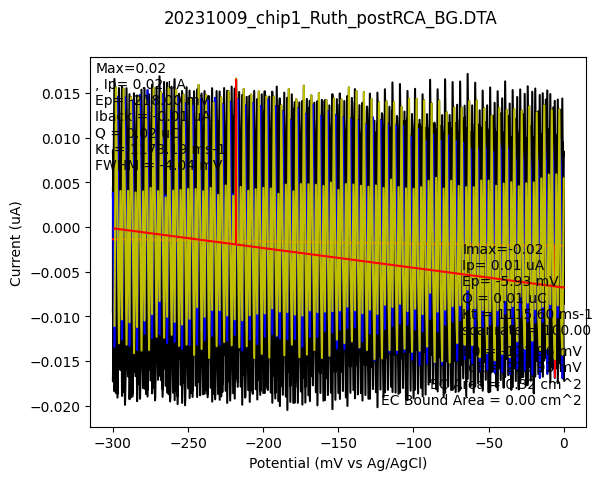

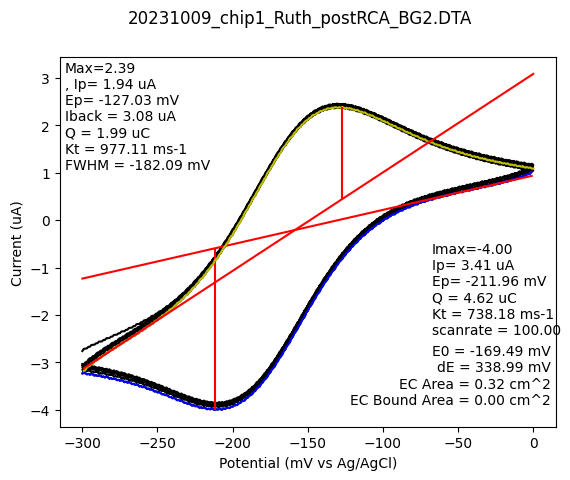

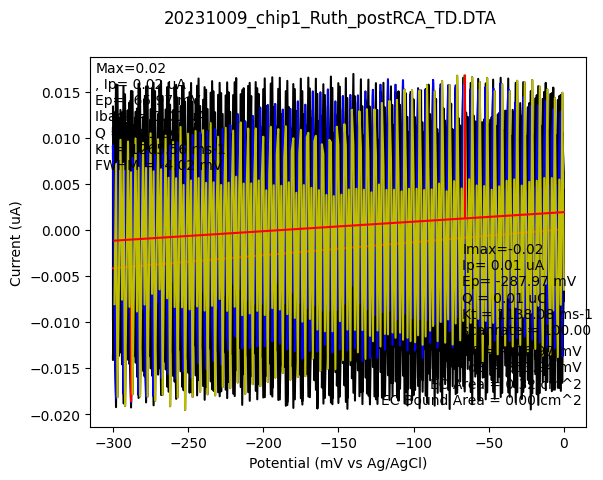

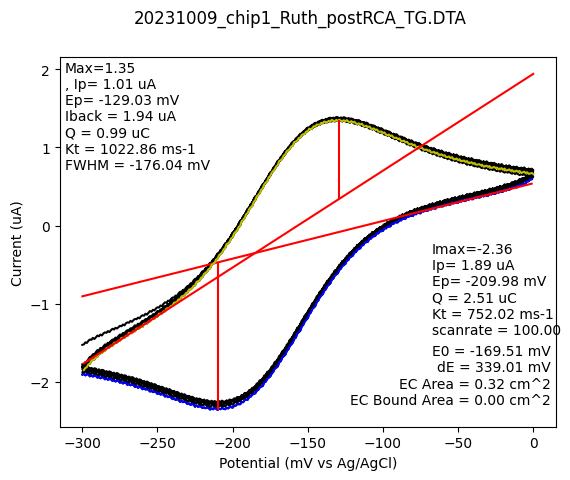

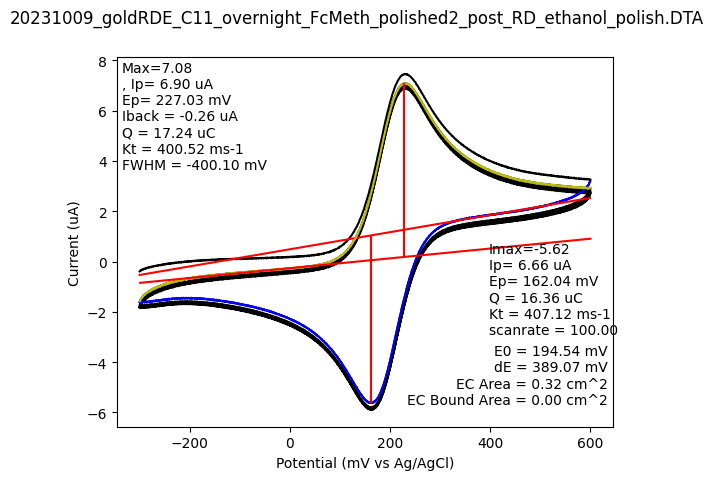

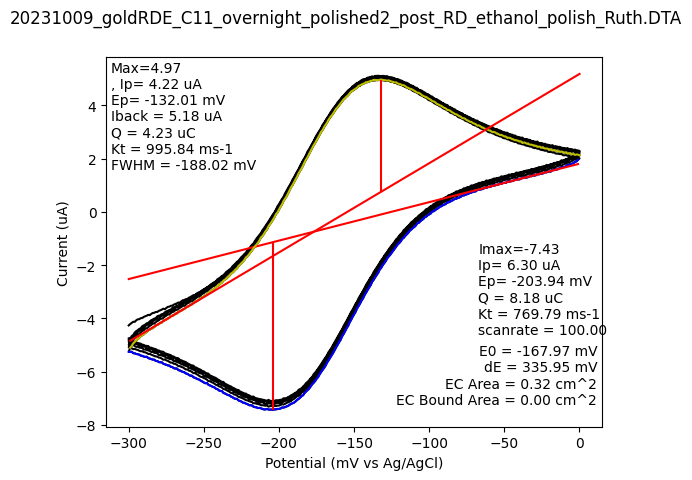

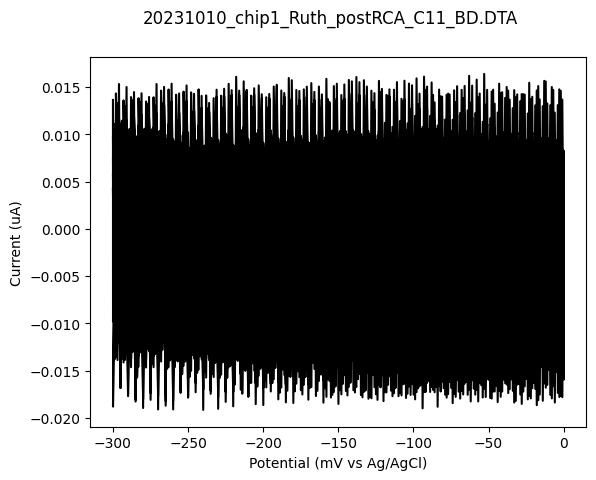

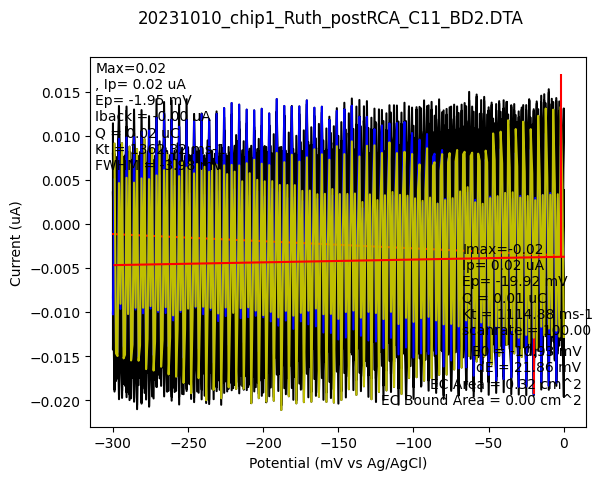

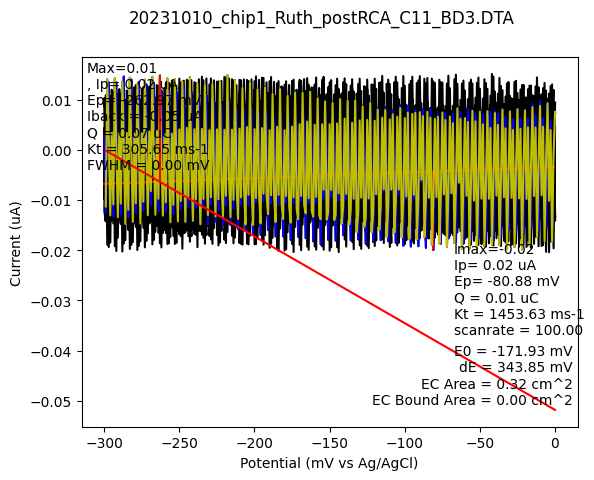

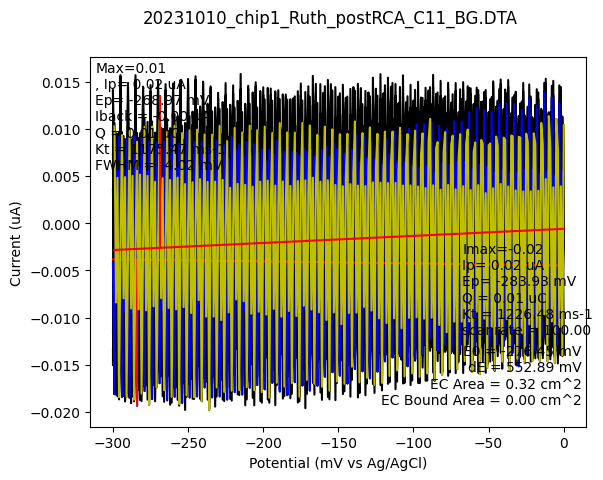

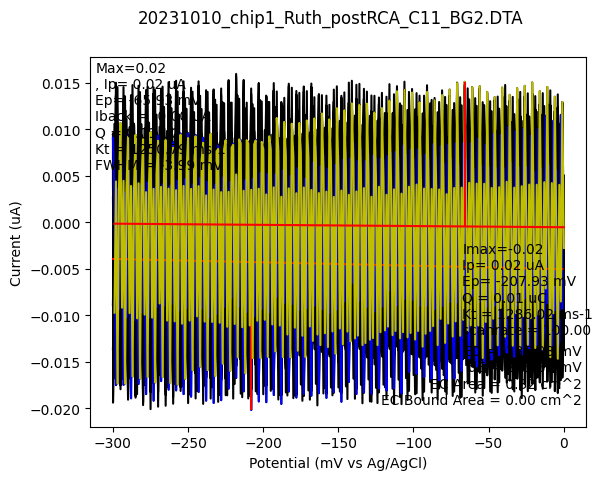

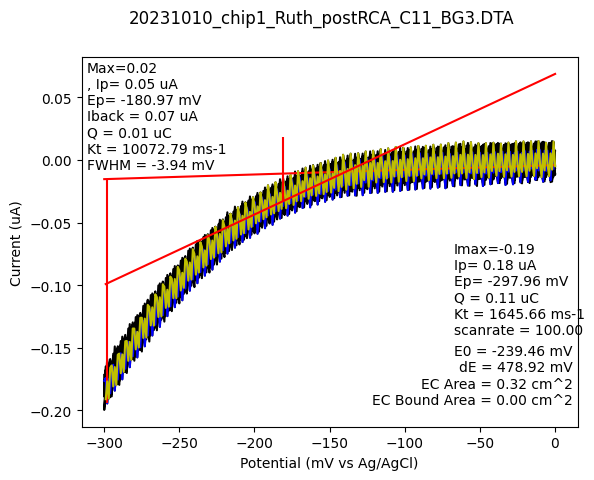

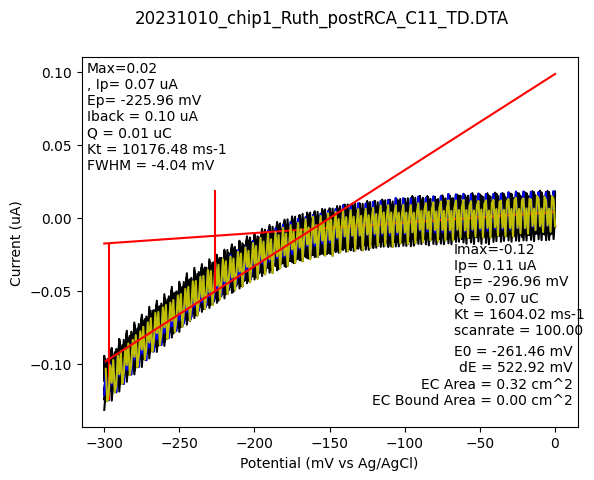

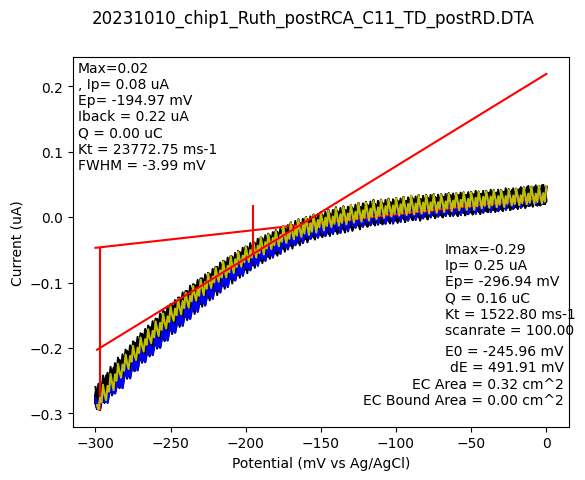

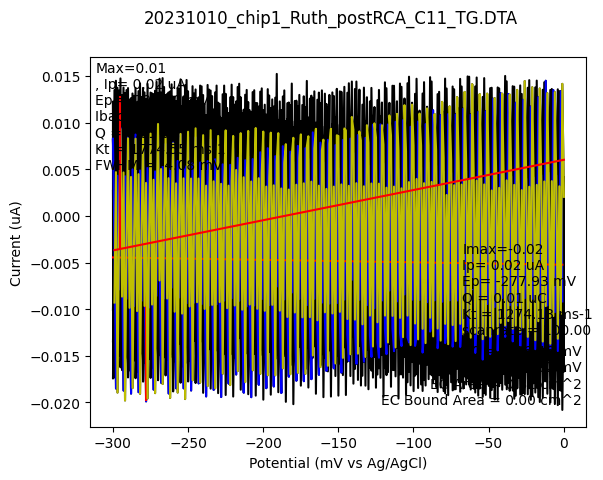

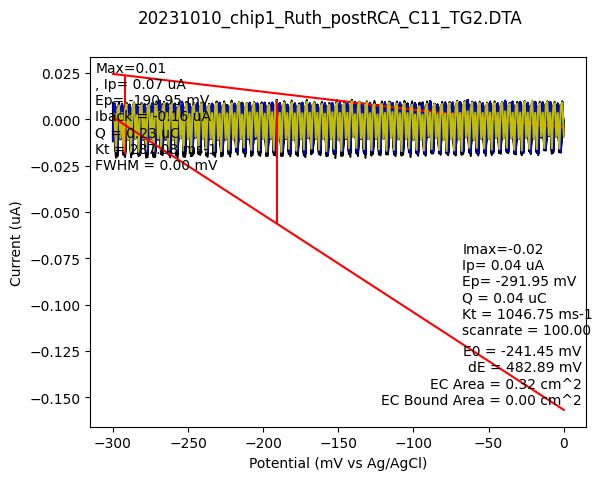

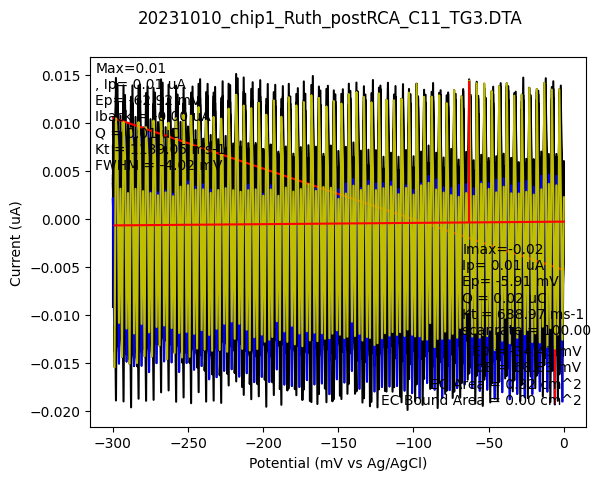

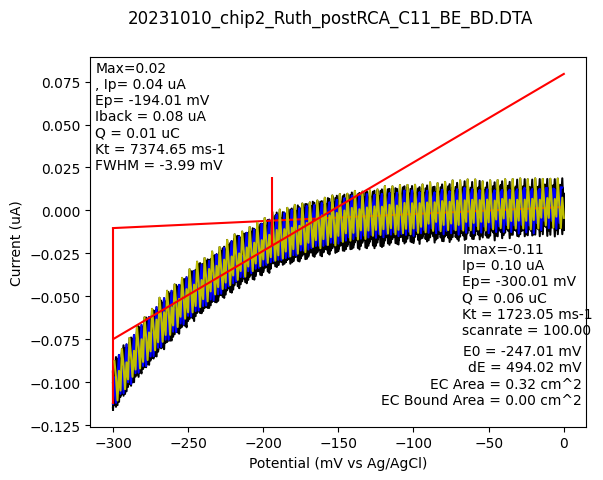

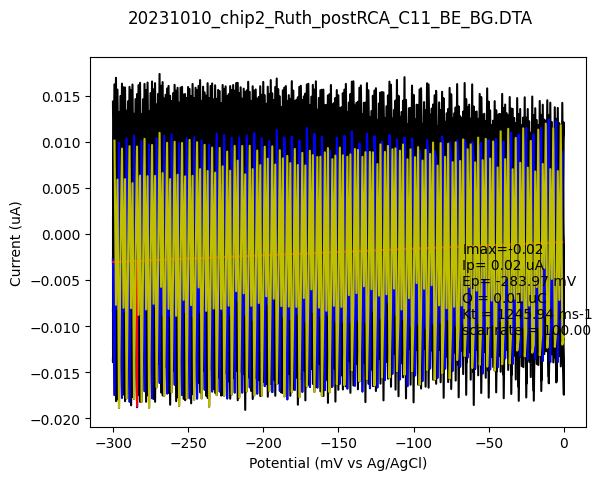

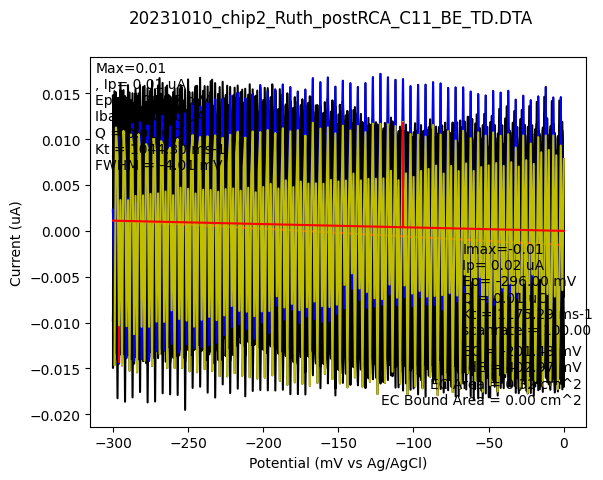

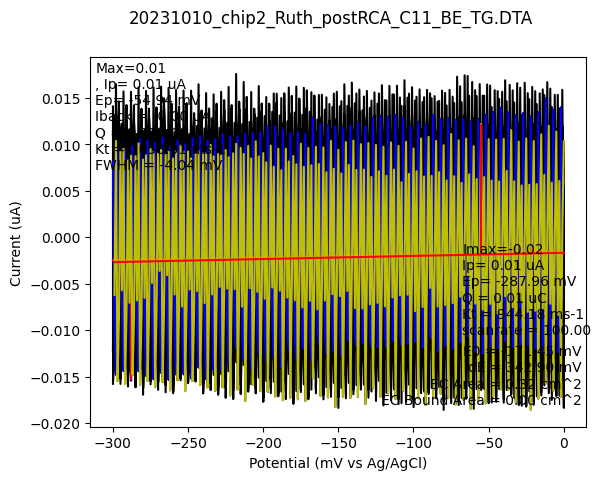

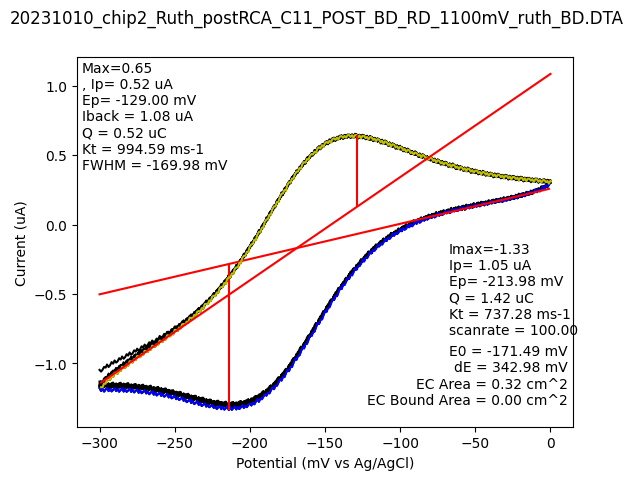

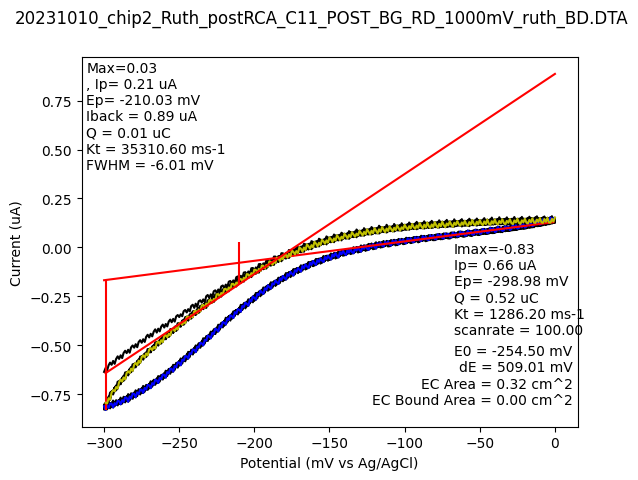

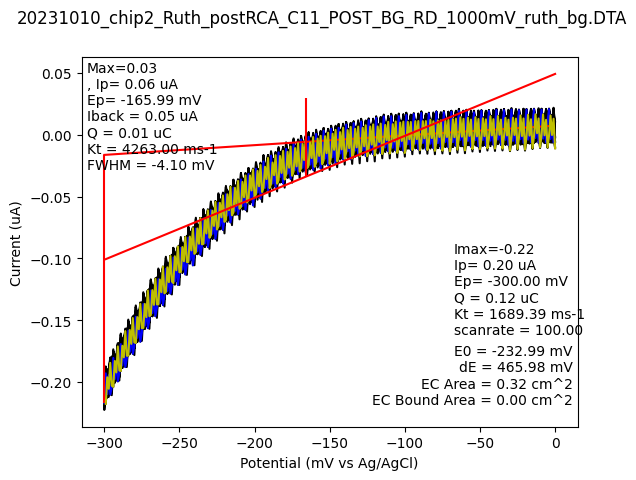

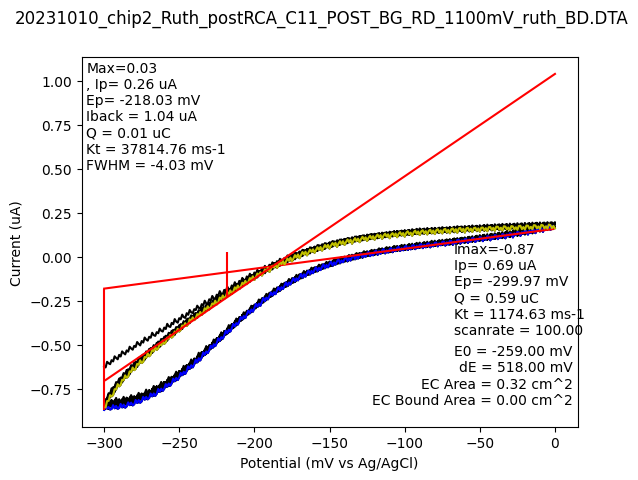

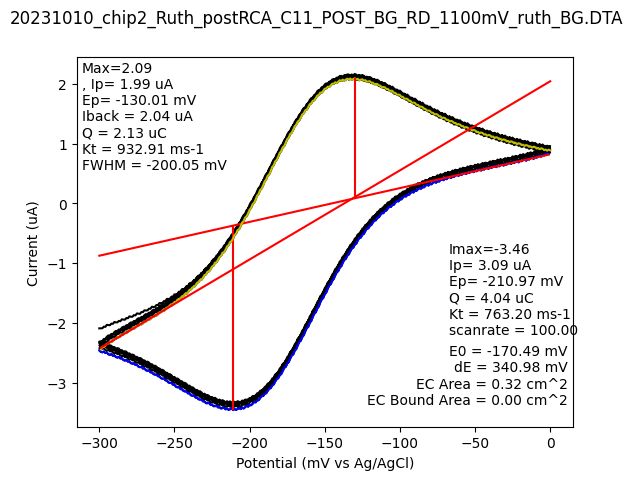

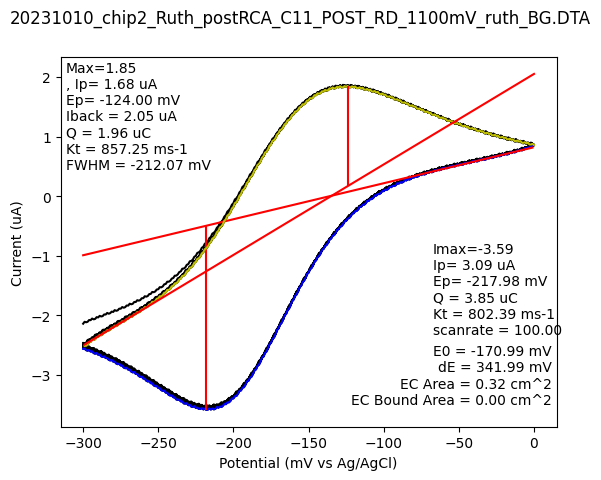

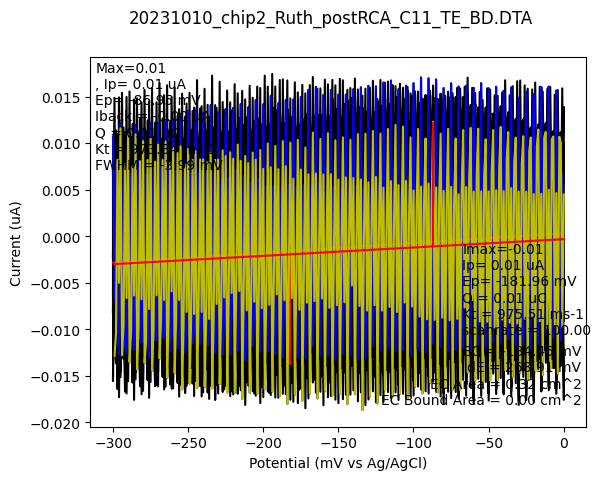

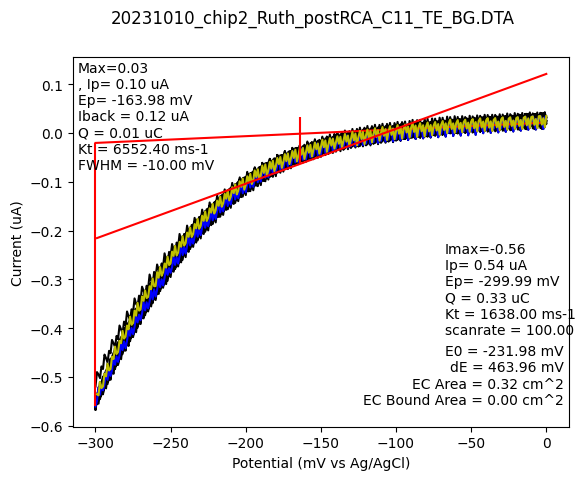

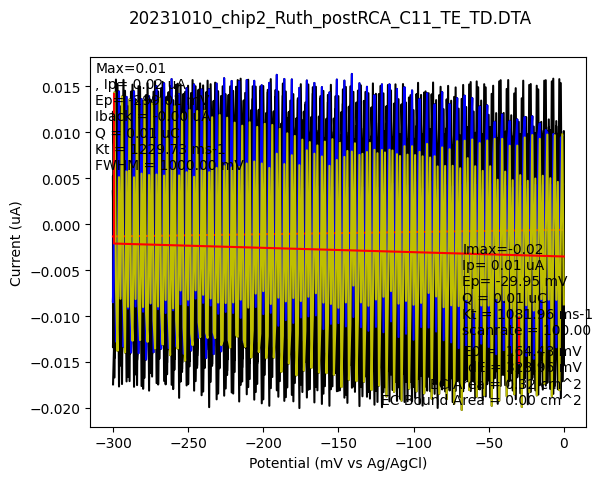

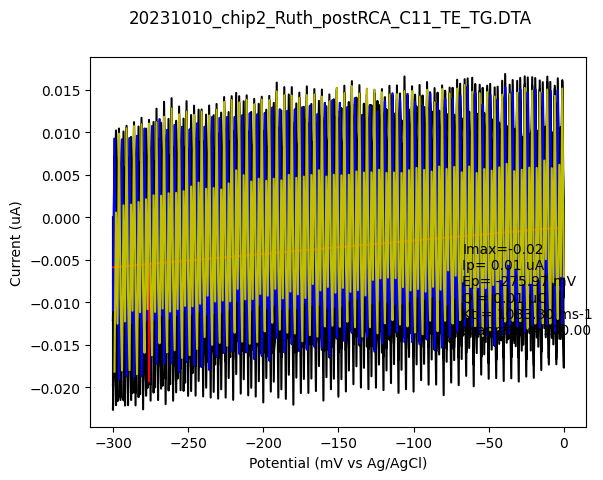

In [4]:


#########################################Enter the folder with the CVs##############################################

allFiles=r'D:\DataTemp\20231010testpad\CVs'

####################################################################################################################
 
if (os.path.isdir(allFiles)):
   outFolder= allFiles
   allFiles = glob.glob(allFiles + "\\*.dta")
   for file in allFiles:print(f"'{file}'")
else:
   outFolder=os.path.dirname(allFiles)
   allFiles=[allFiles]


CVs={}
cc=0
tables ={}
for dataDir in allFiles:
    try:
        #if the extension is .csv then load through a pine
        if os.path.splitext(dataDir)[1]=='.csv' or os.path.splitext(dataDir)[1]=='':
            cv=loadPine(dataDir)
        elif os.path.splitext(dataDir)[1].lower()=='.dta':
            cv=loadGamry(dataDir)
        
        filename = os.path.basename(dataDir)
        params=DuckParams(filename,cv,RedoxConcentration_M=5e-3)
        plt.savefig(outFolder + "\\" + filename + '.jpg')
        plt.show() 
        tables[filename]=params
    except:
        pass
 
 
t=pd.DataFrame(tables).transpose()
t.to_csv(outFolder + "\\tables.csv") 

'D:\DataTemp\20231010testpad\RD\20231010_chip1_Ruth_postRCA_C11_BG_2ND_ethanolRD_.DTA'
'D:\DataTemp\20231010testpad\RD\20231010_chip1_Ruth_postRCA_C11_BG_POST2ND_ethanolRD_.DTA'
'D:\DataTemp\20231010testpad\RD\20231010_chip1_Ruth_postRCA_C11_BG_POST_ethanolRD_.DTA'
'D:\DataTemp\20231010testpad\RD\20231010_chip1_Ruth_postRCA_C11_BG_RD_ethanol.DTA'
'D:\DataTemp\20231010testpad\RD\20231010_chip1_Ruth_postRCA_C11_TD_2ND_ethanolRD_.DTA'
'D:\DataTemp\20231010testpad\RD\20231010_chip1_Ruth_postRCA_C11_TD_3rd_ethanolRD_.DTA'
'D:\DataTemp\20231010testpad\RD\20231010_chip1_Ruth_postRCA_C11_TD_POST3rd_ethanolRD_.DTA'
'D:\DataTemp\20231010testpad\RD\20231010_chip1_Ruth_postRCA_C11_TD_POST_ethanolRD_.DTA'
'D:\DataTemp\20231010testpad\RD\20231010_chip1_Ruth_postRCA_C11_TD_RD.DTA'
'D:\DataTemp\20231010testpad\RD\20231010_chip1_Ruth_postRCA_C11_TD_RD_ethanol.DTA'
'D:\DataTemp\20231010testpad\RD\20231010_token2_BE_BD_RD_1100mV.DTA'
'D:\DataTemp\20231010testpad\RD\20231010_token2_TE_BG_RD_1000mV.DTA'
'D

d:\PythonProj\Auto-EC\AutoEC_Lib.py:182: RuntimeWarning: divide by zero encountered in divide
  return A*np.exp( -.5*((x-x0)/sig)**2)


peak 1.0718786513555125 range: 1.0294492610349133,1.1143080416761117 amp:9.229258750171205e-07
Mean shift 2
Guassian Fit
peak 1.0718528214115917 range: 1.0288630614200946,1.1148425814030887 amp:9.393049017173731e-07
Mean shift 3


d:\PythonProj\Auto-EC\AutoEC_Lib.py:182: RuntimeWarning: divide by zero encountered in divide
  return A*np.exp( -.5*((x-x0)/sig)**2)


Guassian Fit


d:\PythonProj\Auto-EC\AutoEC_Lib.py:182: RuntimeWarning: divide by zero encountered in divide
  return A*np.exp( -.5*((x-x0)/sig)**2)


peak 1.0706232828715172 range: 1.030684182802639,1.1105623829403954 amp:8.591989414085752e-07
Mean shift 4
Guassian Fit
Mean shift 5
Guassian Fit


d:\PythonProj\Auto-EC\AutoEC_Lib.py:182: RuntimeWarning: divide by zero encountered in divide
  return A*np.exp( -.5*((x-x0)/sig)**2)


peak 1.0707923590665867 range: 1.0319562318376316,1.1096284862955417 amp:8.052028760048111e-07
155.20817093861325
1.07 V, 5.41E+00 +/- 5.72E-01 molecules/nm^2, 5.41E+14  +/- 5.72E+13 molecules/cm^2


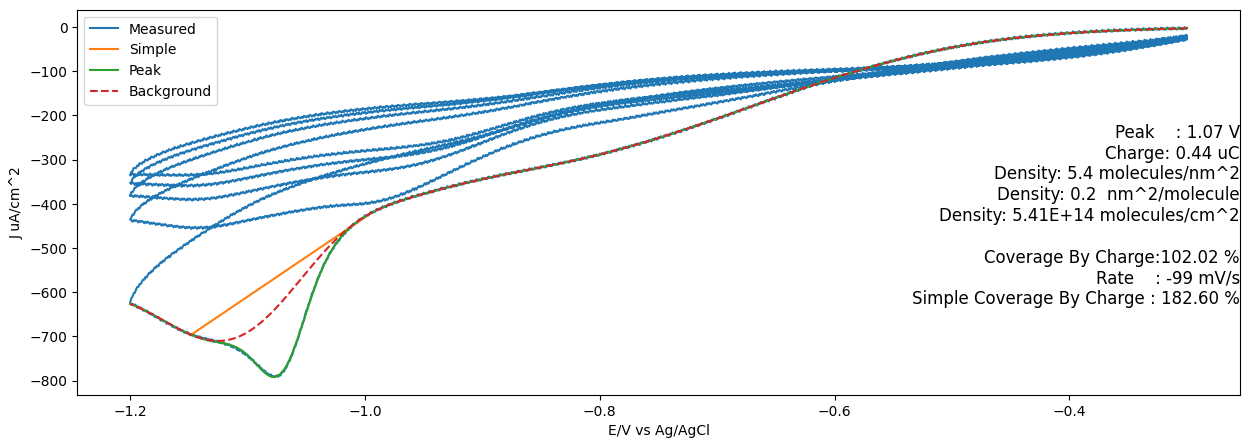

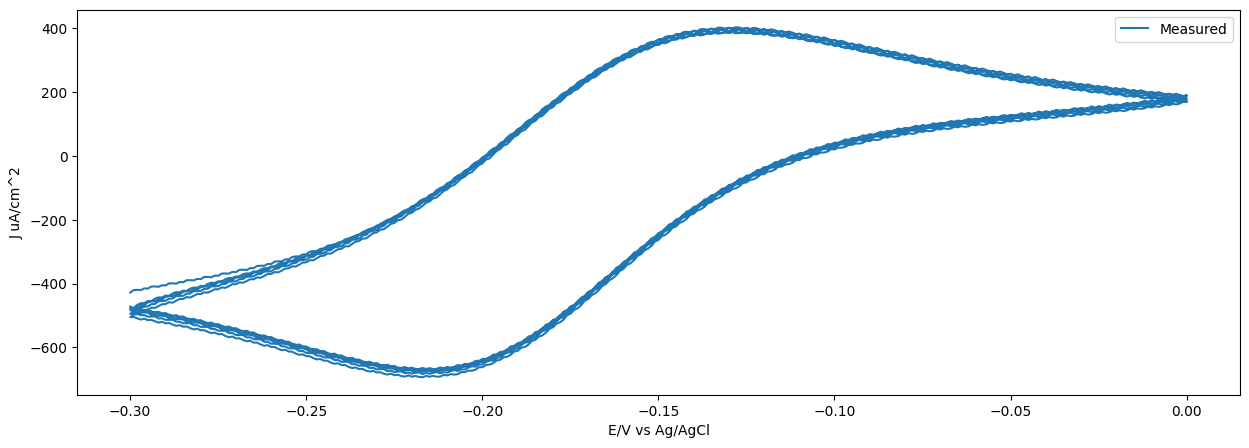

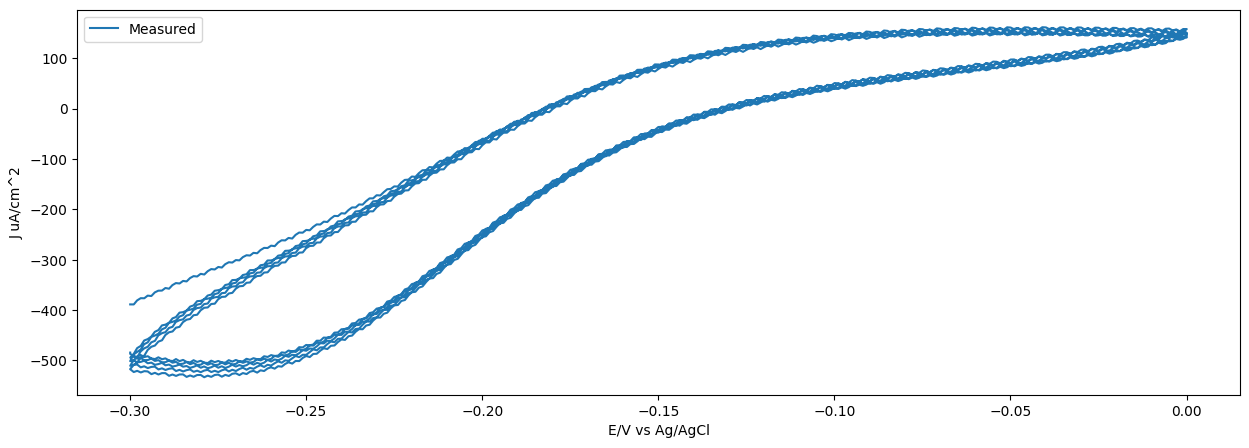

Estimate bandwidth
Mean shift 1
Guassian Fit
Mean shift 2
Guassian Fit
Mean shift 3
Guassian Fit
Mean shift 4
Guassian Fit


d:\PythonProj\Auto-EC\AutoEC_Lib.py:182: RuntimeWarning: divide by zero encountered in divide
  return A*np.exp( -.5*((x-x0)/sig)**2)


peak 1.114467988460719 range: 1.0515641297097345,1.1773718472117034 amp:9.716399424502038e-06
Mean shift 5
Guassian Fit


d:\PythonProj\Auto-EC\AutoEC_Lib.py:182: RuntimeWarning: divide by zero encountered in divide
  return A*np.exp( -.5*((x-x0)/sig)**2)


peak 1.114365611002572 range: 1.0514619497968818,1.177269272208262 amp:9.71848379694115e-06
718.7790958965331
0.87 V, 9.48E+01 +/- 1.16E-02 molecules/nm^2, 9.48E+15  +/- 1.16E+12 molecules/cm^2


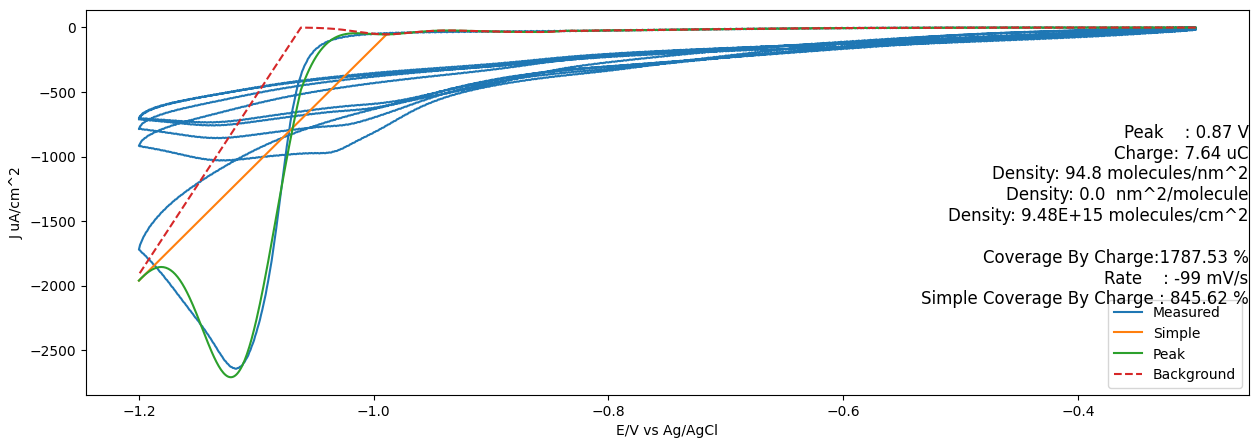

Estimate bandwidth
Mean shift 1
Guassian Fit
peak 1.0448744600737672 range: 1.0043095086336051,1.0854394115139292 amp:4.5427630153957337e-07
Mean shift 2


d:\PythonProj\Auto-EC\AutoEC_Lib.py:182: RuntimeWarning: divide by zero encountered in divide
  return A*np.exp( -.5*((x-x0)/sig)**2)


Guassian Fit
Mean shift 3
Guassian Fit
Mean shift 4
Guassian Fit


d:\PythonProj\mlStuff\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\PythonProj\Auto-EC\AutoEC_Lib.py:182: RuntimeWarning: divide by zero encountered in divide
  return A*np.exp( -.5*((x-x0)/sig)**2)


peak 1.0449688757080005 range: 1.084687132009485,1.0052506194065158 amp:4.410037775427894e-07
Mean shift 5
Guassian Fit
peak 1.044966570714206 range: 1.0842581843553276,1.0056749570730843 amp:4.278194410382232e-07


d:\PythonProj\Auto-EC\AutoEC_Lib.py:182: RuntimeWarning: divide by zero encountered in divide
  return A*np.exp( -.5*((x-x0)/sig)**2)


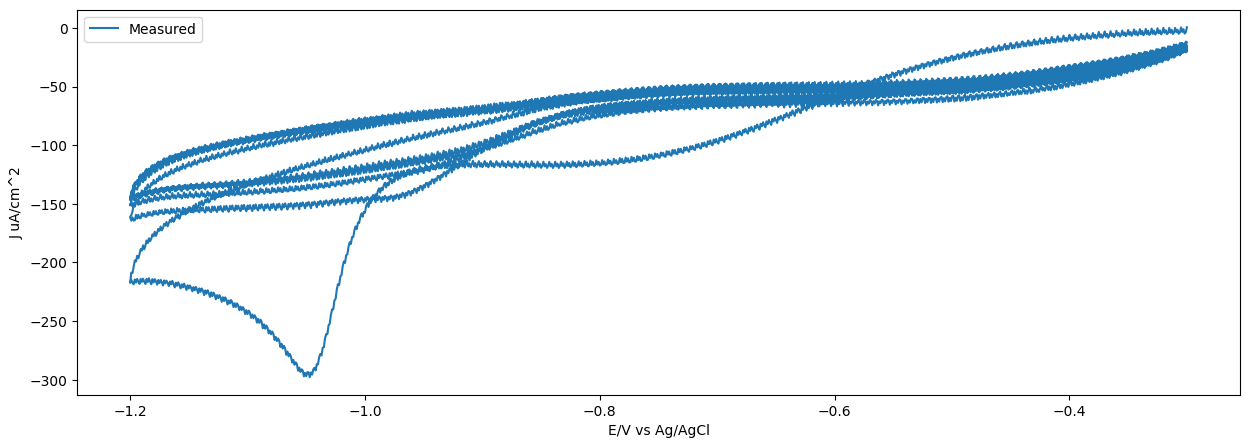

Estimate bandwidth
Mean shift 1
Guassian Fit
Mean shift 2


d:\PythonProj\Auto-EC\AutoEC_Lib.py:182: RuntimeWarning: divide by zero encountered in divide
  return A*np.exp( -.5*((x-x0)/sig)**2)


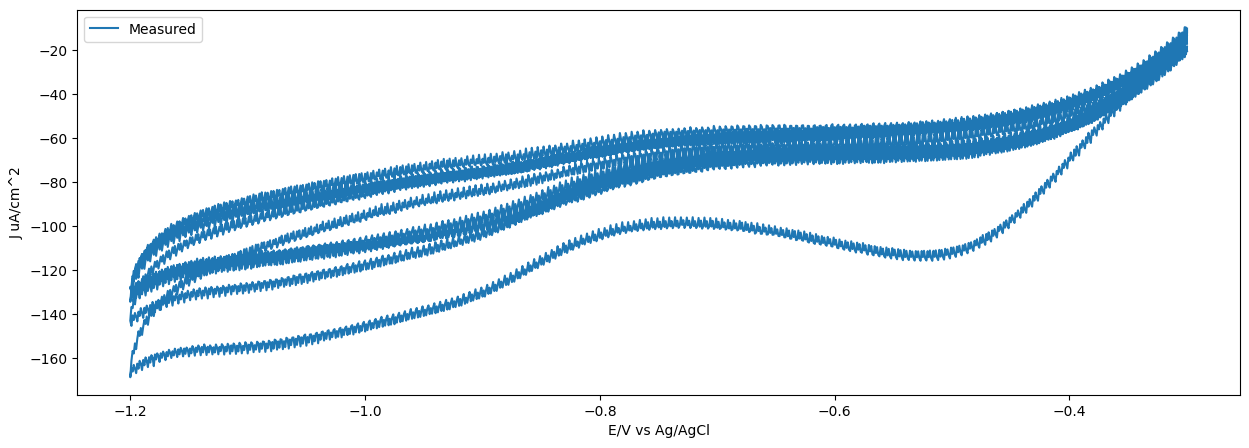

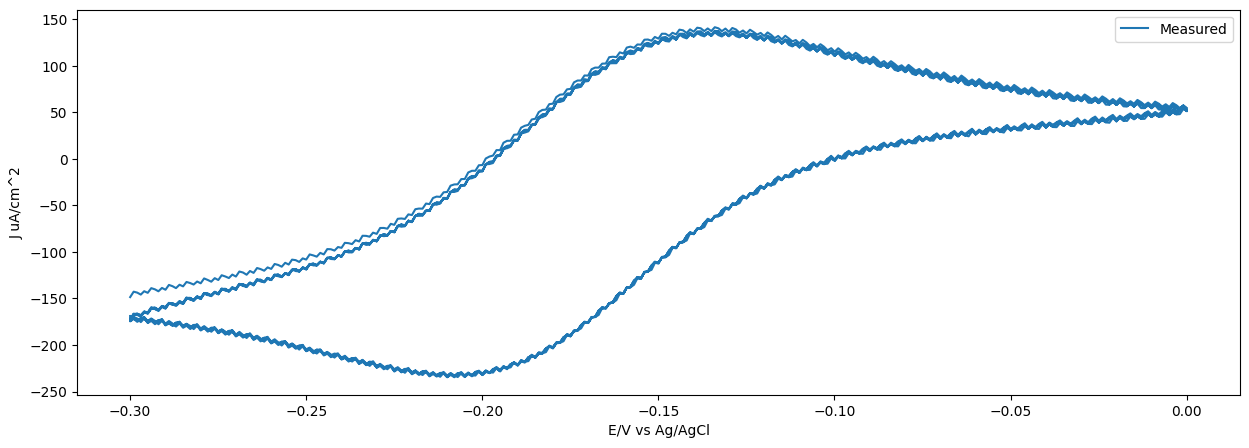

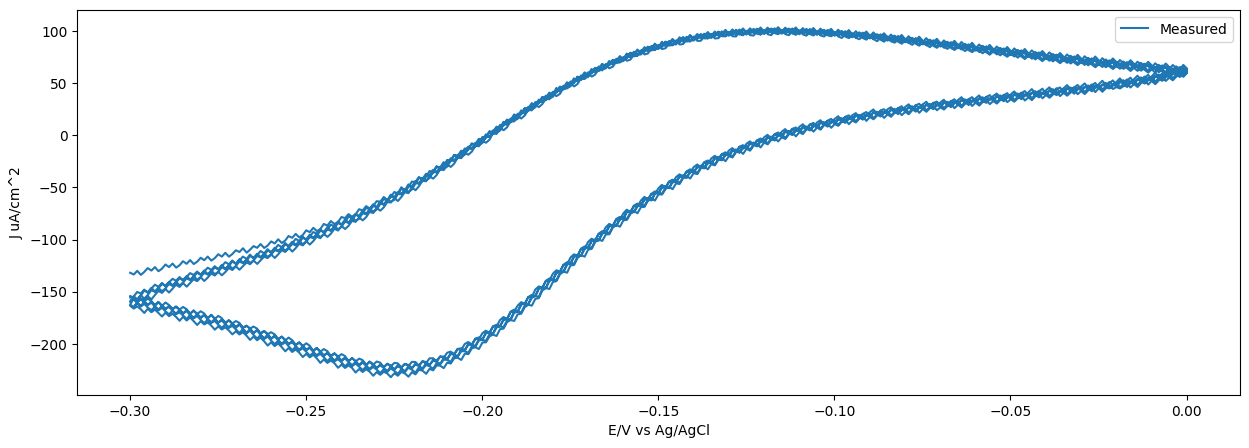

Estimate bandwidth
Mean shift 1
Guassian Fit
Mean shift 2
Guassian Fit


d:\PythonProj\mlStuff\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
d:\PythonProj\Auto-EC\AutoEC_Lib.py:182: RuntimeWarning: divide by zero encountered in divide
  return A*np.exp( -.5*((x-x0)/sig)**2)


peak 1.212106772234205 range: 1.1799922880379623,1.2442212564304476 amp:1.710744244319211e-06
Mean shift 3
Guassian Fit


d:\PythonProj\Auto-EC\AutoEC_Lib.py:182: RuntimeWarning: divide by zero encountered in divide
  return A*np.exp( -.5*((x-x0)/sig)**2)


peak 1.211884695486987 range: 1.1801340327082048,1.2436353582657693 amp:1.7186968887683682e-06
Mean shift 4


: 

In [5]:

######################################### Enter the folder with the RD ##############################################

allFiles=r'D:\DataTemp\20231010testpad\RD'

#allFiles=r'C:\Users\bashc\Downloads\20231005_token2_11OH_red_des_FA.DTA'

####################################################################################################################

if (os.path.isdir(allFiles)):
   outFolder= allFiles
   allFiles = glob.glob(allFiles + "\\*.dta")
   for file in allFiles:print(f"'{file}'")
else:
   outFolder=os.path.dirname(allFiles)
   allFiles=[allFiles]
 
 

CVs={}
cc=0
for dataDir in allFiles:
   try:
      table='Peak Potential (mV), Molecules, Molecules/nm^2, error, Molecules/ cm^2, error\t'
      #if the extension is .csv then load through a pine
      if os.path.splitext(dataDir)[1]=='.csv' or os.path.splitext(dataDir)[1]=='':
         cv=loadPine(dataDir)
      elif os.path.splitext(dataDir)[1].lower()=='.dta':
         cv=loadGamry(dataDir)
      
      filename = os.path.basename(dataDir)
      
      plt.figure(figsize=(15,5))
      plt.title="Reductive CVs " + filename
      
      area_um2= 400*400*3.14159 #um^2
      area_cm2 = area_um2*1e-8 #cm^2
      
      plt.plot(cv.V,cv.C/area_cm2*1e+6,label='Measured')
      CV=cv.loc[(cv.scanrate<0) & (cv.cycle==0)]


     
      plt.xlabel("E/V vs Ag/AgCl")
      plt.ylabel("J uA/cm^2") 
      try:
         guesses,bestcurves,flatCharge,VV=FindMolecules(CV,area_cm2)
         energy=np.sum([x[1]*1/x[0] for x in guesses])/np.sum([1/x[0] for x in guesses])
         Mol=np.sum([x[-1]*1/x[0] for x in guesses])/np.sum([1/x[0] for x in guesses])
         Q=np.sum([x[-2]*1/x[0] for x in guesses])/np.sum([1/x[0] for x in guesses])
         sdMol=np.std([x[-1] for x in guesses])
         #400um diameter
         print(flatCharge)
         
         
         area_um2 = area_cm2*10000*10000
         area_nm2 = area_um2*1000*1000


         textstr='Peak    : %.2f V\nCharge: %0.2f uC\nDensity: %.1f molecules/nm^2\nDensity: %.1f  nm^2/molecule\nDensity: %.2E molecules/cm^2\n'%(  energy, Q*1e6,Mol/area_nm2,area_nm2/Mol,  Mol/area_cm2 )
         textstr=textstr + f'\nCoverage By Charge:{Q*1e6/area_cm2/85*100:.2f} %\n'
         textstr+='Rate    : %d mV/s\n'%(np.mean(CV.scanrate*1000))
         textstr+=f'Simple Coverage By Charge : {flatCharge/85*100:.2f} %\n'

         plt.gcf().text(.9,.25,  textstr  , horizontalalignment='right', fontsize=12)

         print( '%.2f V, %.2E +/- %.2E molecules/nm^2, %.2E  +/- %.2E molecules/cm^2'%(  energy, Mol/area_nm2, sdMol/area_nm2, Mol/area_cm2, sdMol/area_cm2))
         table+='%.2f , %.2E,%.2E,%.2E,%.2E'%(  energy, Mol/area_nm2, sdMol/area_nm2, Mol/area_cm2, sdMol/area_cm2)
      except:
         pass
      plt.legend()
      #plt.xlim([-1.2, .9])
      plt.savefig(outFolder + "\\" + filename + '.jpg')
      plt.show()    
   except :
      pass

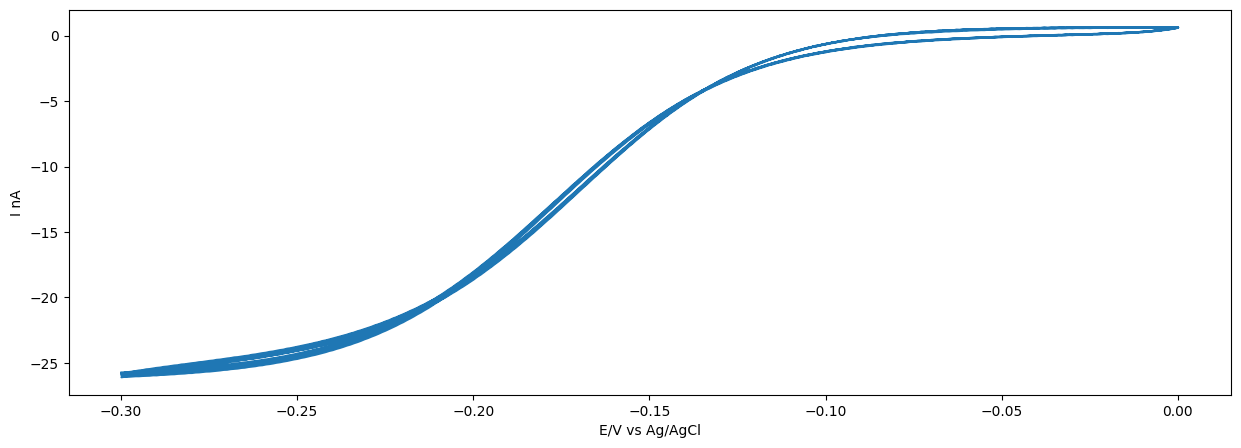

In [3]:

######################################### Enter the folder with the microelectrodes ##############################################

allFiles=r'C:\Users\bashc\Downloads\20231011_W065A2_E1_CV_10mMRuth_RCA.DTA'

####################################################################################################################

if (os.path.isdir(allFiles)):
   outFolder= allFiles
   allFiles = glob.glob(allFiles + "\\*.dta")
   for file in allFiles:print(f"'{file}'")
else:
   outFolder=os.path.dirname(allFiles)
   allFiles=[allFiles]
 
 

CVs={}
cc=0
for dataDir in allFiles:

      table='Peak Potential (mV), Molecules, Molecules/nm^2, error, Molecules/ cm^2, error\t'
      #if the extension is .csv then load through a pine
      if os.path.splitext(dataDir)[1]=='.csv' or os.path.splitext(dataDir)[1]=='':
         cv=loadPine(dataDir)
      elif os.path.splitext(dataDir)[1].lower()=='.dta':
         cv=loadGamry(dataDir)
      
      filename = os.path.basename(dataDir)
      
      plt.figure(figsize=(15,5))
      plt.title="MicroElectrode " + filename
      plt.plot(cv.V,cv.C*1e9,label='Measured')
      plt.xlabel("E/V vs Ag/AgCl")
      plt.ylabel("I nA") 


In [4]:
RedoxConcentration_M=10e-3
maxCurrent =np.max(np.abs(cv.C))
Diffusion = 8.70E-06 # HAR cm^2/s
Concentration=RedoxConcentration_M * 1e-3 #M
scanRate = np.max(np.abs(cv.scanrate))

t= np.max(cv.V)/scanRate/2

R= 8.314 #J/mol/K 
F=96485 #C/mol
T=293  #K 
n=1
l=10 #um
r=2 #um

Id=np.abs(n*F*Diffusion*(l*1e-4)*Concentration*np.pi/np.log( 4*Diffusion*t/(r*1e-4)**2)*1e9)
# C/mol * cm^2/s * cm * mol  /cm^2 * 1e9 
Id,maxCurrent*1e9

(28.810349452795016, 26.0931)

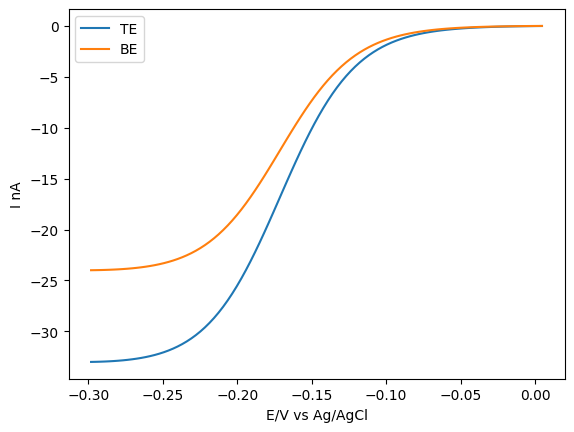

In [16]:
E=np.linspace(7,-5,100)
Ev=E*R*T/F-.172

l=11 #um
r=3 #um

II =  Id/(1+1*np.exp(E)) 



t=5-(Ev-np.min(Ev))/.1+.172/.1
Id2=np.abs(n*F*Diffusion*(l*1e-4)*Concentration*np.pi/np.log( 4*Diffusion*t/(r*1e-4)**2)*1e9)

plt.plot(Ev,-1*II*Id2/3.2 , label='TE')


l=8 #um
r=3 #um

II =  Id/(1+1*np.exp(E)) 



t=5-(Ev-np.min(Ev))/.1+.172/.1
Id2=np.abs(n*F*Diffusion*(l*1e-4)*Concentration*np.pi/np.log( 4*Diffusion*t/(r*1e-4)**2)*1e9)

plt.plot(Ev,-1*II*Id2/3.2 , label='BE')
#plt.plot(Ev,-1*II )
#plt.plot(cv.V,cv.C*1e9,label='Measured')
plt.xlabel("E/V vs Ag/AgCl")
plt.ylabel("I nA")
plt.legend()
plt.show()

In [19]:
2*3.1415*1*96485*5e-4*8.7e-6*1e-6*1e9


2.63703635925